# SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la carga de los módulos necesarios:

In [94]:
import pandas as pd
import numpy as np

import lightgbm as lgb

Cargamos con **pandas** lentamente el dataset. Sólo vamos a trabajar con el primer conjunto de datos que es el más pequeño. Con un poco más de paciencia podrá usar los conjuntos más pesados. 

In [95]:
df_train = pd.read_csv("../../../datasets/competencia3_2022.csv")

Columns (154) have mixed types. Specify dtype option on import or set low_memory=False.


In [96]:
Xtrain = df_train[(df_train["foto_mes"] >= 202101) & (df_train["foto_mes"] <= 202105)]
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)

Separamos también todos los casos de **BAJAS+1** y **BAJAS+2**

In [97]:
Xbajas = df_train.query("foto_mes >= 202101 and foto_mes <= 202105 and clase_ternaria != 'CONTINUA'")

In [98]:
print(Xtrain.shape)
print(ytrain.shape)
print(Xbajas.shape)

(813213, 155)
(813213,)
(9481, 155)


Y nos deshacemos del target y limpiamos un poco la memoria.

In [99]:
Xtrain = Xtrain.drop("clase_ternaria", axis=1)
Xbajas = Xbajas.drop("clase_ternaria", axis=1)

del(df_train)

## Hacemos un modelo **LGBM**

In [100]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(Xtrain, ytrain)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'learning_rate': 0.05,
    'verbose': 2,
    'max_bin': 15,
    'min_data_in_leaf': 4000,
    'verbose': 0,
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.171377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


## Importancia de variables

In [101]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia


,Features,Importances
8,mrentabilidad_annual,164
33,mprestamos_personales,119
22,mcuentas_saldo,118
10,mactivos_margen,113
72,mcomisiones_mantenimiento,93
...,...,...
105,catm_trx_other,0
106,matm_other,0
36,cprestamos_hipotecarios,0
34,cprestamos_prendarios,0


## Obtenemos shap values

Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

In [102]:
import shap

In [103]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(Xbajas)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Consolidamos los valores de **SHAP** para cada variable y para cada **BAJA+\***

In [104]:
shap_bajas = pd.DataFrame(shap_values[0], columns = Xbajas.columns)
shap_bajas

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo
0,-0.001424,0.072945,-0.000026,0.0,-0.004555,0.007756,0.009268,-0.039548,0.170213,0.000524,...,0.0,-0.007606,-0.021651,-0.008498,0.0,-0.014452,0.0,0.028779,0.0,-0.120109
1,0.008775,0.097002,0.000551,0.0,-0.008978,0.023262,0.007510,0.036021,-0.139105,-0.006532,...,0.0,0.002789,0.005079,-0.008036,0.0,0.003487,0.0,-0.039716,0.0,-0.089774
2,0.000184,0.150179,-0.000010,0.0,-0.001131,-0.133263,0.006827,-0.002099,0.041227,0.014749,...,0.0,0.001279,0.003741,0.004173,0.0,-0.028986,0.0,-0.002536,0.0,0.031301
3,-0.005740,0.075007,-0.000060,0.0,-0.003571,-0.071190,0.001362,0.000541,-0.007108,-0.004469,...,0.0,-0.000745,0.001627,-0.000466,0.0,-0.020291,0.0,0.011059,0.0,-0.074905
4,-0.001353,0.075864,-0.000026,0.0,-0.008013,-0.057191,0.006612,-0.023699,0.241150,0.003484,...,0.0,-0.004026,-0.001998,-0.007808,0.0,-0.061730,0.0,0.013285,0.0,-0.150267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9476,0.005849,-0.061362,-0.000807,0.0,-0.003016,0.016544,-0.018488,0.042566,-0.191995,-0.003503,...,0.0,-0.005841,-0.003768,-0.003148,0.0,0.011219,0.0,0.027542,0.0,-0.074038
9477,0.003751,-0.020888,0.001153,0.0,-0.006696,-0.069244,0.008135,0.043965,-0.103296,-0.000164,...,0.0,-0.003064,0.002741,-0.004584,0.0,0.088769,0.0,-0.000909,0.0,-0.086465
9478,0.003255,-0.027428,-0.000174,0.0,-0.007787,-0.034077,-0.001945,0.047963,-0.130306,0.000069,...,0.0,-0.002898,0.002588,-0.002800,0.0,0.065376,0.0,-0.003740,0.0,-0.109997
9479,0.003324,-0.023936,0.002095,0.0,-0.006136,-0.080830,0.007743,0.047253,-0.092425,-0.000284,...,0.0,-0.003901,0.002562,-0.003877,0.0,0.057923,0.0,0.002162,0.0,-0.079914


Y consolidamos sus importancias

In [105]:
shap_importancias = shap_bajas.abs().mean().sort_values(ascending=False)
shap_importancias

ctrx_quarter               0.984101
cpayroll_trx               0.464429
mpayroll                   0.421839
mprestamos_personales      0.265960
mtarjeta_visa_consumo      0.260284
                             ...   
cforex                     0.000000
cinversion1                0.000000
Master_msaldodolares       0.000000
Master_mconsumosdolares    0.000000
mforex_buy                 0.000000
Length: 154, dtype: float64

In [176]:
df_shap_imp = pd.DataFrame({'column': shap_importancias.index, 'value': shap_importancias.values})
df_shap_imp[0:20]

,column,value
0,ctrx_quarter,0.984101
1,cpayroll_trx,0.464429
2,mpayroll,0.421839
3,mprestamos_personales,0.265960
4,mtarjeta_visa_consumo,0.260284
5,mcuentas_saldo,0.246746
6,mrentabilidad_annual,0.168255
7,mactivos_margen,0.115092
8,mcaja_ahorro,0.115000
9,mcomisiones_mantenimiento,0.110486


In [106]:
shap_importancias.index

Index(['ctrx_quarter', 'cpayroll_trx', 'mpayroll', 'mprestamos_personales',
       'mtarjeta_visa_consumo', 'mcuentas_saldo', 'mrentabilidad_annual',
       'mactivos_margen', 'mcaja_ahorro', 'mcomisiones_mantenimiento',
       ...
       'cseguro_vivienda', 'Master_delinquency', 'cseguro_auto', 'cinversion2',
       'minversion1_dolares', 'cforex', 'cinversion1', 'Master_msaldodolares',
       'Master_mconsumosdolares', 'mforex_buy'],
      dtype='object', length=154)

## Visualizar shap_values

La librería nos da útiles herramientas para vizualizar la info anterior

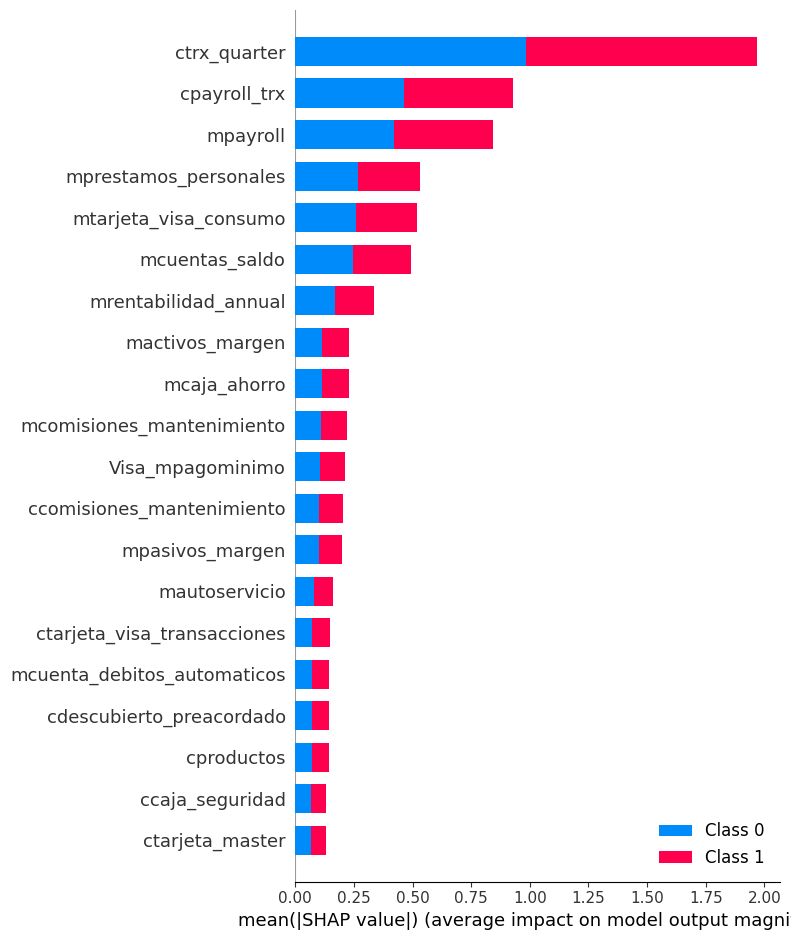

In [107]:
summary_plot = shap.summary_plot(shap_values, Xbajas)

Y ahora debemos empezar a jugar para entender como estan asociadas las variables a los **shap values**

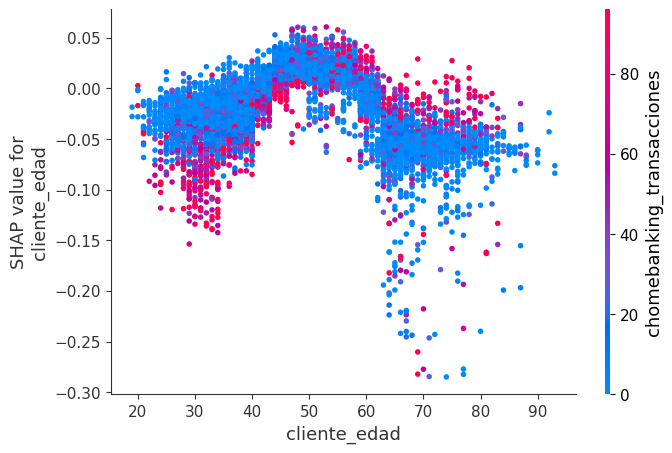

In [108]:
shap.dependence_plot("cliente_edad", shap_values[0], Xbajas)

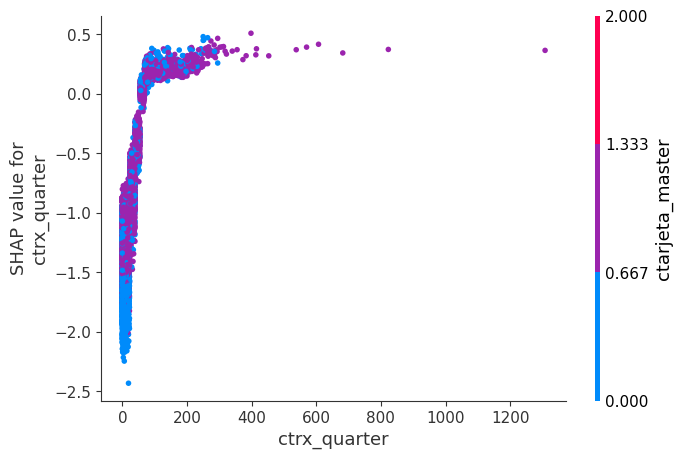

In [109]:
shap.dependence_plot("ctrx_quarter", shap_values[0], Xbajas)

## Clustering

¿Se podrá hacer una clusterización sobre los valores de shap? 

Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Como la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento.

In [110]:
from umap import UMAP
import matplotlib.pyplot as plt


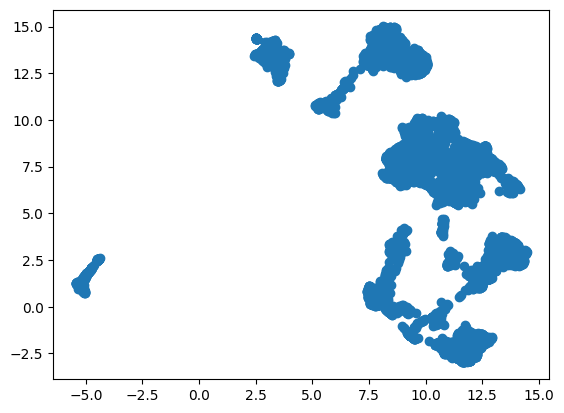

In [111]:
embedding_2d = UMAP(
  n_components=2, n_neighbors=200, random_state=123
).fit_transform(shap_values[0])
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])

In [112]:
embedding_2d.shape

(9481, 2)

In [113]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn_extra.cluster import KMedoids

In [114]:
k = 4
clusterer = KMedoids(n_clusters=k, random_state=100)
cluster_labels = clusterer.fit_predict(embedding_2d)
centers = clusterer.cluster_centers_

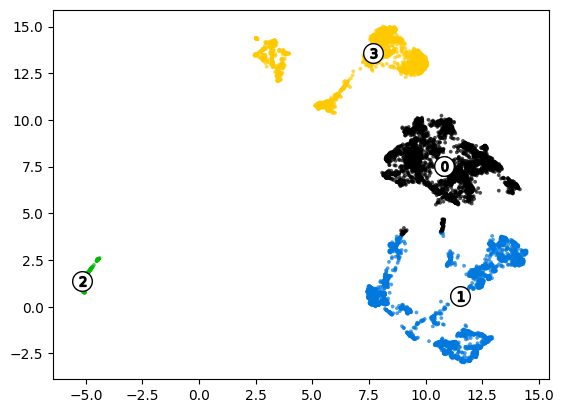

In [115]:
datos = embedding_2d
colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
plt.scatter(
    datos[:, 0], datos[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)

# Draw white circles at cluster centers
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

In [141]:
Xbajas.iloc[clusterer.medoid_indices_][['ctrx_quarter', 'mpayroll', 'cpayroll_trx', 'mprestamos_personales', 
                                        'mtarjeta_visa_consumo', 'mcuentas_saldo', 'mrentabilidad_annual', 
                                        'mactivos_margen', 'mcaja_ahorro', 'mcomisiones_mantenimiento', 'cluster', 
                                        'cliente_edad']]

,ctrx_quarter,mpayroll,cpayroll_trx,mprestamos_personales,mtarjeta_visa_consumo,mcuentas_saldo,mrentabilidad_annual,mactivos_margen,mcaja_ahorro,mcomisiones_mantenimiento,cluster,cliente_edad
4062179,26,0.0,0,0.00,3689.58,35476.61,44266.99,-71.33,49414.77,1774.04,0,66
4192989,2,0.0,0,9930.89,0.00,-21262.57,21903.87,-472.28,0.00,2505.95,1,45
3756953,22,0.0,0,0.00,0.00,54.04,18693.42,6.65,771.76,1774.04,2,50
3742344,76,0.0,0,0.00,16665.45,132443.98,12705.30,-2517.82,30793.51,1774.04,3,69


In [117]:
cluster_labels

array([0, 1, 3, ..., 0, 0, 3], dtype=int64)

In [118]:
clusterer.medoid_indices_

array([7575, 9088, 3722, 3559], dtype=int64)

In [119]:
df_labels = pd.DataFrame(cluster_labels, columns=['cluster'], index = Xbajas.index)
df_labels

,cluster
3401199,0
3401425,1
3401495,3
3401616,2
3401682,1
...,...
4213695,0
4213904,0
4214146,0
4214285,0


In [120]:
Xbajas = Xbajas.join(df_labels["cluster"])

In [121]:
Xbajas

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo,cluster
3401199,31127916,202101,1,0,0,42,277,2649.44,30930.84,2519.56,...,11.0,3485.96,-3448.72,0.0,5103.0,3002.88,2.0,0.0,598.23,0
3401425,31282207,202101,0,0,0,44,292,-2313.80,-3919.05,1225.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3401495,31328871,202101,1,0,0,83,293,335.32,17274.70,1699.39,...,25.0,48368.31,-44473.12,0.0,7490.0,2768.26,4.0,0.0,3964.74,3
3401616,31406150,202101,1,0,0,69,296,567.94,14262.98,1246.04,...,4.0,0.00,-13090.55,0.0,4772.0,0.00,0.0,0.0,0.00,2
3401682,31449517,202101,1,0,0,71,262,1248.52,17804.40,1823.18,...,11.0,1777.09,-2250.51,0.0,5673.0,1759.50,1.0,0.0,82.11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4213695,208266612,202105,1,0,0,46,8,-5475.63,-12933.53,0.00,...,5.0,0.00,-5173.10,0.0,222.0,0.00,0.0,0.0,574.77,0
4213904,209952469,202105,0,0,0,73,6,154.40,1550.48,0.00,...,5.0,0.00,NaN,NaN,165.0,NaN,NaN,NaN,0.00,0
4214146,212188655,202105,1,0,0,31,3,152.73,816.88,71.61,...,5.0,0.00,NaN,NaN,47.0,NaN,NaN,NaN,0.00,0
4214285,212659672,202105,0,0,0,66,2,0.00,0.00,0.00,...,5.0,0.00,NaN,NaN,47.0,NaN,NaN,NaN,0.00,0


In [122]:
Xbajas.groupby(['cluster']).size()

cluster
0    3464
1    3223
2     370
3    2424
dtype: int64

In [123]:
Xbajas[Xbajas['cluster'] == 1]

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo,cluster
3401425,31282207,202101,0,0,0,44,292,-2313.80,-3919.05,1225.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3401682,31449517,202101,1,0,0,71,262,1248.52,17804.40,1823.18,...,11.0,1777.09,-2250.51,0.0,5673.0,1759.5,1.0,0.0,82.11,1
3402551,31995750,202101,1,0,1,54,320,987.59,10883.84,192.97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3403555,32642239,202101,0,0,0,61,40,2370.86,2420.90,2356.97,...,4.0,0.00,NaN,NaN,1211.0,NaN,NaN,NaN,0.00,1
3403563,32645693,202101,0,0,1,76,320,453.42,3084.30,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4213092,205722860,202105,1,0,0,51,11,1703.11,6460.47,1594.29,...,12.0,0.00,NaN,NaN,307.0,NaN,NaN,NaN,0.00,1
4213138,205878060,202105,0,0,0,31,11,1775.58,6699.62,1592.20,...,5.0,0.00,NaN,NaN,309.0,NaN,NaN,NaN,0.00,1
4213257,206413989,202105,0,0,0,37,10,2351.40,4605.91,2249.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4213308,206580154,202105,1,0,0,33,10,1669.01,4791.34,1607.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [124]:
shap_importancias.index

Index(['ctrx_quarter', 'cpayroll_trx', 'mpayroll', 'mprestamos_personales',
       'mtarjeta_visa_consumo', 'mcuentas_saldo', 'mrentabilidad_annual',
       'mactivos_margen', 'mcaja_ahorro', 'mcomisiones_mantenimiento',
       ...
       'cseguro_vivienda', 'Master_delinquency', 'cseguro_auto', 'cinversion2',
       'minversion1_dolares', 'cforex', 'cinversion1', 'Master_msaldodolares',
       'Master_mconsumosdolares', 'mforex_buy'],
      dtype='object', length=154)

## Resumenes

In [142]:
Xbajas.groupby(['cluster']).agg({
    'ctrx_quarter': ['min', 'max', 'mean', 'median'],
    'mcuentas_saldo': ['min', 'max', 'mean', 'median'],
    'mcaja_ahorro': ['min', 'max', 'mean', 'median'],
    'mrentabilidad_annual': ['min', 'max', 'mean', 'median']
})

ctrx_quarter                         mcuentas_saldo               \
                 min   max       mean median            min          max   
cluster                                                                    
0                  0    54  23.833430   24.0     -179606.40  14392871.70   
1                  0    30   5.699659    3.0    -1777746.61     98965.83   
2                  0   264  27.632432   16.0    -1094335.15   3808293.81   
3                  0  1308  91.848597   79.0    -1347146.44  12680249.96   

                                mcaja_ahorro                            \
                 mean    median          min         max          mean   
cluster                                                                  
0        38286.228649    76.695          0.0  2742788.96  12316.182180   
1       -19853.391570 -6869.450          0.0   262396.24    378.774856   
2         2141.245757 -2369.485          0.0  1247445.55  11893.362676   
3        66598.809072  3553.150          0.0  3989708.85  35754.513482   

                  mrentabilidad_annual                                      \
           median                  min        max          mean     median   
cluster                                                                      
0         656.445            -87403.52  482765.63  11264.614605   6639.525   
1           0.000           -192280.71  919537.76  17015.673159  10094.870   
2           6.745           -210278.71  472646.39  19570.536486  11679.365   
3        7018.470           -181477.65  772601.07  19735.938358   9580.425   

        cliente_edad                        
                 min max       mean median  
cluster                                     
0                 21  93  49.256928   48.0  
1                 19  90  47.525287   45.0  
2                 21  90  50.186486   47.0  
3                 20  92  47.560644   46.0

In [128]:
Xbajas.groupby(['cluster']).agg({
    'mpayroll': ['min', 'max', 'mean', 'median'],
    'cpayroll_trx': ['min', 'max', 'mean', 'median'],
})

mpayroll                                  cpayroll_trx                \
             min         max          mean median          min max      mean   
cluster                                                                        
0            0.0    28152.00     16.351807    0.0            0   4  0.001443   
1            0.0     6667.56      2.068743    0.0            0   3  0.000931   
2            0.0    12580.42    124.543324    0.0            0   2  0.029730   
3            0.0  3523523.08  25171.388069    0.0            0  19  0.396452   

                
        median  
cluster         
0          0.0  
1          0.0  
2          0.0  
3          0.0

In [129]:
Xbajas.groupby(['cluster']).agg({
    'mtarjeta_visa_consumo': ['min', 'max', 'mean', 'median']
})

mtarjeta_visa_consumo                                   
                          min        max          mean    median
cluster                                                         
0                         0.0  810033.97   7694.992835  1172.825
1                         0.0   31116.17    241.553702     0.000
2                         0.0   16406.93     54.018757     0.000
3                         0.0  455312.33  20170.918783  6862.850

In [130]:
Xbajas.groupby(['cluster']).agg({
    'mprestamos_personales': ['min', 'max', 'mean', 'median'],
})

mprestamos_personales                                 
                          min         max          mean median
cluster                                                       
0                         0.0    76822.33    431.428868    0.0
1                         0.0    26227.08    402.700645    0.0
2                         0.0    26183.16    189.739216    0.0
3                         0.0  1372139.34  26063.695264    0.0

In [131]:
Xbajas.groupby(['cluster']).agg({
    'mactivos_margen': ['min', 'max', 'mean', 'median'],
    'mcomisiones_mantenimiento': ['min', 'max', 'mean', 'median'],
})

mactivos_margen                                  \
                    min        max        mean   median   
cluster                                                   
0             -39907.34   42601.18 -110.966472    0.000   
1             -44104.66  134010.69  787.406311  127.320   
2             -31369.26   23630.00  453.754297   34.825   
3             -32044.47  172782.83 -250.363552 -115.315   

        mcomisiones_mantenimiento                                 
                              min      max         mean   median  
cluster                                                           
0                        -6826.67  4229.34   987.653196  1364.94  
1                        -5784.53  4090.11  1422.932277  1774.04  
2                        -9452.83  3947.05  1020.736405  1364.94  
3                        -8598.79  4469.03   915.720470     0.00

## shap values por cluster

### cluster 0

In [149]:
Xbajas_c0 = Xbajas[Xbajas['cluster'] == 0]
Xbajas_c0 = Xbajas_c0.drop("cluster", axis = 1)

In [150]:
shap_values_c0 = explainer.shap_values(Xbajas_c0)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [151]:
shap_bajas_c0 = pd.DataFrame(shap_values_c0[0], columns = Xbajas_c0.columns)
shap_bajas_c0

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo
0,-0.001424,0.072945,-0.000026,0.0,-0.004555,0.007756,0.009268,-0.039548,0.170213,0.000524,...,0.0,-0.007606,-0.021651,-0.008498,0.0,-0.014452,0.0,0.028779,0.0,-0.120109
1,-0.015473,0.139021,-0.000327,0.0,-0.001513,0.005201,-0.021857,0.031174,-0.174310,-0.002861,...,0.0,0.001298,-0.002024,-0.010058,0.0,0.007333,0.0,0.020033,0.0,-0.092645
2,0.004091,0.094960,-0.000185,0.0,-0.007225,-0.051456,0.012970,0.023492,-0.135149,-0.002956,...,0.0,0.002392,0.006020,-0.005118,0.0,-0.017598,0.0,-0.001449,0.0,-0.078463
3,-0.000199,0.154671,-0.000086,0.0,-0.001803,-0.071057,-0.000068,0.015430,0.121564,0.000052,...,0.0,0.003650,0.003207,0.007982,0.0,-0.062604,0.0,-0.012950,0.0,0.045352
4,0.005499,0.128535,-0.000013,0.0,-0.003685,-0.036686,-0.015090,-0.015429,-0.157756,0.000542,...,0.0,-0.000932,0.000157,-0.017369,0.0,0.014286,0.0,-0.004632,0.0,-0.153957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3459,0.001394,-0.040582,-0.000032,0.0,-0.005278,-0.042428,0.010702,-0.045734,-0.256522,0.000252,...,0.0,-0.004744,0.001579,0.003732,0.0,0.017154,0.0,0.063287,0.0,-0.053781
3460,0.005849,-0.061362,-0.000807,0.0,-0.003016,0.016544,-0.018488,0.042566,-0.191995,-0.003503,...,0.0,-0.005841,-0.003768,-0.003148,0.0,0.011219,0.0,0.027542,0.0,-0.074038
3461,0.003751,-0.020888,0.001153,0.0,-0.006696,-0.069244,0.008135,0.043965,-0.103296,-0.000164,...,0.0,-0.003064,0.002741,-0.004584,0.0,0.088769,0.0,-0.000909,0.0,-0.086465
3462,0.003255,-0.027428,-0.000174,0.0,-0.007787,-0.034077,-0.001945,0.047963,-0.130306,0.000069,...,0.0,-0.002898,0.002588,-0.002800,0.0,0.065376,0.0,-0.003740,0.0,-0.109997


In [163]:
shap_importancias_c0 = shap_bajas_c0.abs().mean().sort_values(ascending=False)
shap_importancias_c0

ctrx_quarter               0.878175
cpayroll_trx               0.466144
mpayroll                   0.441152
mtarjeta_visa_consumo      0.224210
mprestamos_personales      0.219441
                             ...   
cinversion2                0.000000
cforex_sell                0.000000
Master_msaldodolares       0.000000
Master_mconsumosdolares    0.000000
mforex_buy                 0.000000
Length: 154, dtype: float64

In [168]:
df0_shap_imp = pd.DataFrame({'column': shap_importancias_c0.index, 'value': shap_importancias_c0.values})
df0_shap_imp[0:20]

,column,value
0,ctrx_quarter,0.878175
1,cpayroll_trx,0.466144
2,mpayroll,0.441152
3,mtarjeta_visa_consumo,0.224210
4,mprestamos_personales,0.219441
5,mcuentas_saldo,0.191263
6,mrentabilidad_annual,0.182424
7,mcaja_ahorro,0.135238
8,mactivos_margen,0.130639
9,Visa_mpagominimo,0.118602


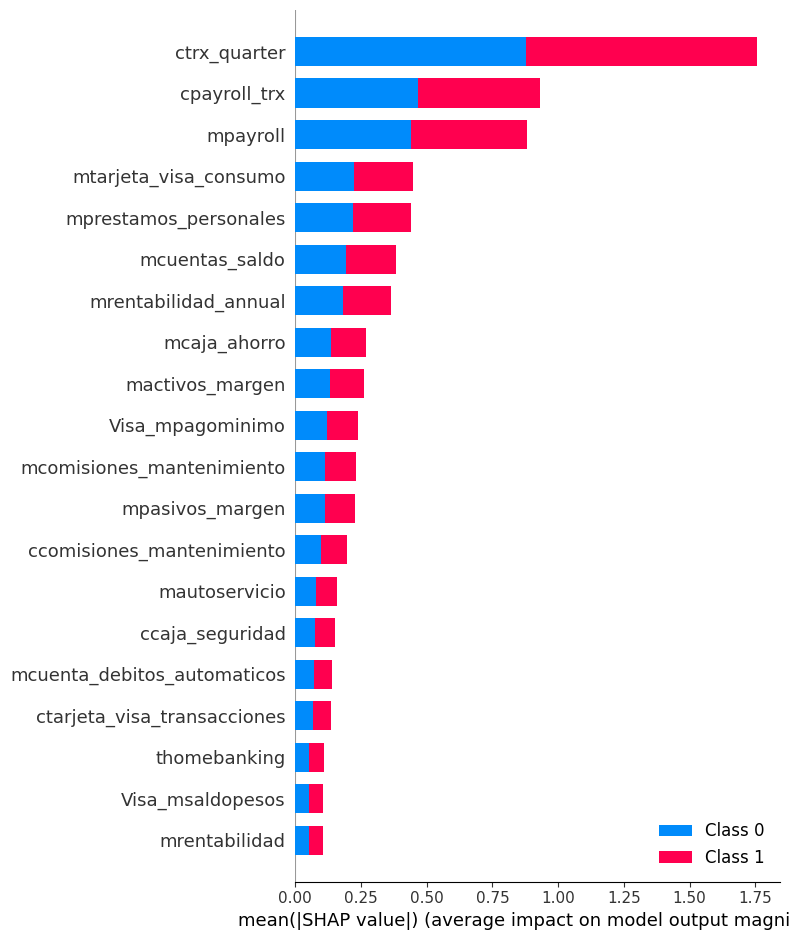

In [164]:
summary_plot = shap.summary_plot(shap_values_c0, Xbajas_c0)

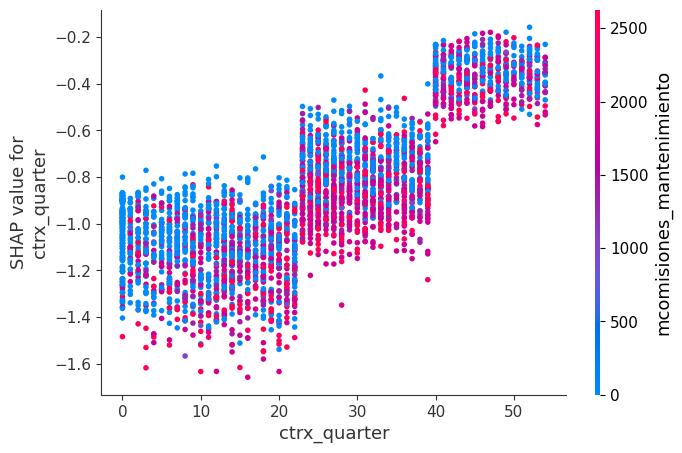

In [154]:
shap.dependence_plot("ctrx_quarter", shap_values_c0[0], Xbajas_c0)

### cluster 1

In [169]:
Xbajas_c1 = Xbajas[Xbajas['cluster'] == 1]
Xbajas_c1 = Xbajas_c1.drop("cluster", axis = 1)
shap_values_c1 = explainer.shap_values(Xbajas_c1)
shap_bajas_c1 = pd.DataFrame(shap_values_c1[0], columns = Xbajas_c1.columns)
shap_importancias_c1 = shap_bajas_c1.abs().mean().sort_values(ascending=False)
shap_importancias_c1

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


ctrx_quarter             1.527342
cpayroll_trx             0.400088
mpayroll                 0.399417
mcuentas_saldo           0.365901
mtarjeta_visa_consumo    0.319434
                           ...   
minversion1_pesos        0.000000
cforex_buy               0.000000
cinversion1              0.000000
mplazo_fijo_pesos        0.000000
mforex_buy               0.000000
Length: 154, dtype: float64

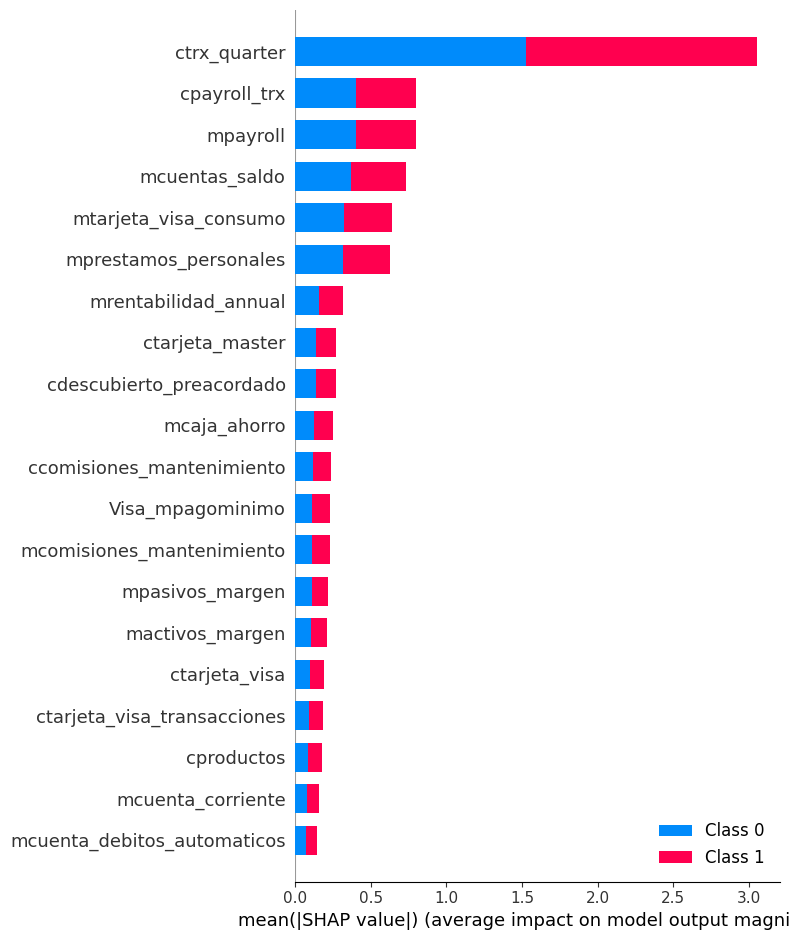

In [172]:
summary_plot = shap.summary_plot(shap_values_c1, Xbajas_c1)

In [173]:
df1_shap_imp = pd.DataFrame({'column': shap_importancias_c1.index, 'value': shap_importancias_c1.values})
df1_shap_imp[0:20]

,column,value
0,ctrx_quarter,1.527342
1,cpayroll_trx,0.400088
2,mpayroll,0.399417
3,mcuentas_saldo,0.365901
4,mtarjeta_visa_consumo,0.319434
5,mprestamos_personales,0.312509
6,mrentabilidad_annual,0.158009
7,ctarjeta_master,0.135977
8,cdescubierto_preacordado,0.133705
9,mcaja_ahorro,0.125162


### cluster 2

In [157]:
Xbajas_c2 = Xbajas[Xbajas['cluster'] == 2]
Xbajas_c2 = Xbajas_c2.drop("cluster", axis = 1)
shap_values_c2 = explainer.shap_values(Xbajas_c2)
shap_bajas_c2 = pd.DataFrame(shap_values_c2[0], columns = Xbajas_c2.columns)
shap_importancias_c2 = shap_bajas_c2.abs().mean().sort_values(ascending=False)
shap_importancias_c2

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


ctrx_quarter               1.339608
Visa_status                1.001458
mpayroll                   0.582012
cpayroll_trx               0.505744
mtarjeta_visa_consumo      0.395091
                             ...   
minversion1_pesos          0.000000
cforex_buy                 0.000000
Master_msaldodolares       0.000000
Master_mconsumosdolares    0.000000
mforex_buy                 0.000000
Length: 154, dtype: float64

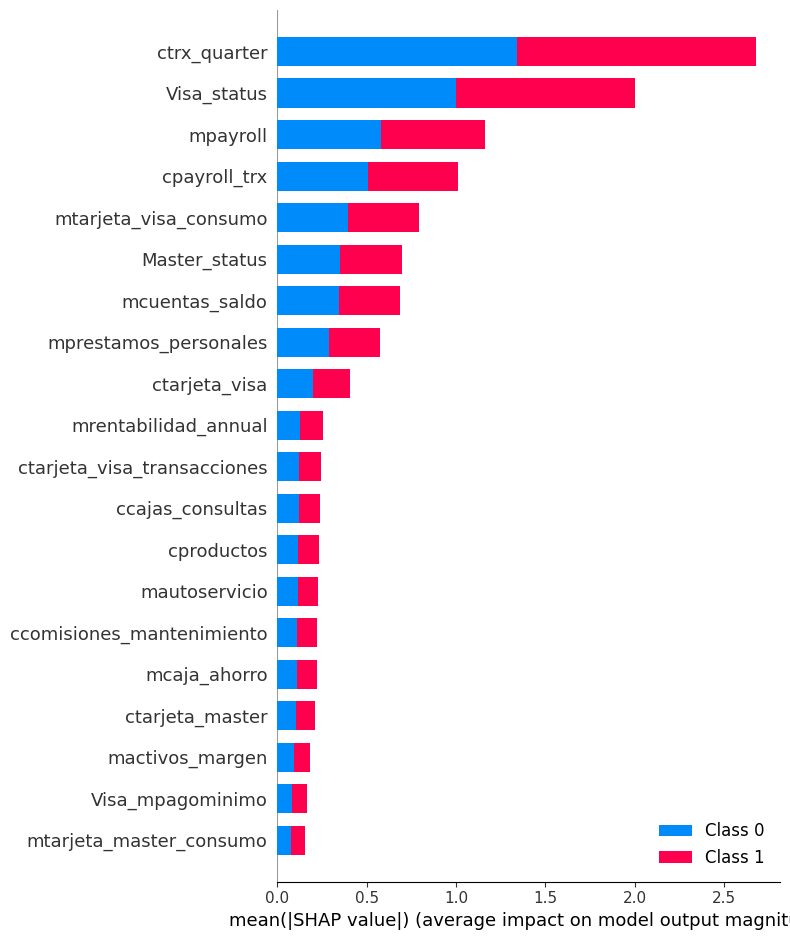

In [158]:
summary_plot = shap.summary_plot(shap_values_c2, Xbajas_c2)

In [174]:
df2_shap_imp = pd.DataFrame({'column': shap_importancias_c2.index, 'value': shap_importancias_c2.values})
df2_shap_imp[0:20]

,column,value
0,ctrx_quarter,1.339608
1,Visa_status,1.001458
2,mpayroll,0.582012
3,cpayroll_trx,0.505744
4,mtarjeta_visa_consumo,0.395091
5,Master_status,0.348375
6,mcuentas_saldo,0.343925
7,mprestamos_personales,0.288476
8,ctarjeta_visa,0.202065
9,mrentabilidad_annual,0.126679


### cluster 3

In [159]:
Xbajas_c3 = Xbajas[Xbajas['cluster'] == 3]
Xbajas_c3 = Xbajas_c3.drop("cluster", axis = 1)
shap_values_c3 = explainer.shap_values(Xbajas_c3)
shap_bajas_c3 = pd.DataFrame(shap_values_c3[0], columns = Xbajas_c3.columns)
shap_importancias_c3 = shap_bajas_c3.abs().mean().sort_values(ascending=False)
shap_importancias_c3

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


cpayroll_trx             0.541221
mpayroll                 0.399602
ctrx_quarter             0.358905
mprestamos_personales    0.267109
mtarjeta_visa_consumo    0.212611
                           ...   
cforex_buy               0.000000
cinversion1              0.000000
mplazo_fijo_pesos        0.000000
Master_msaldodolares     0.000000
mforex_buy               0.000000
Length: 154, dtype: float64

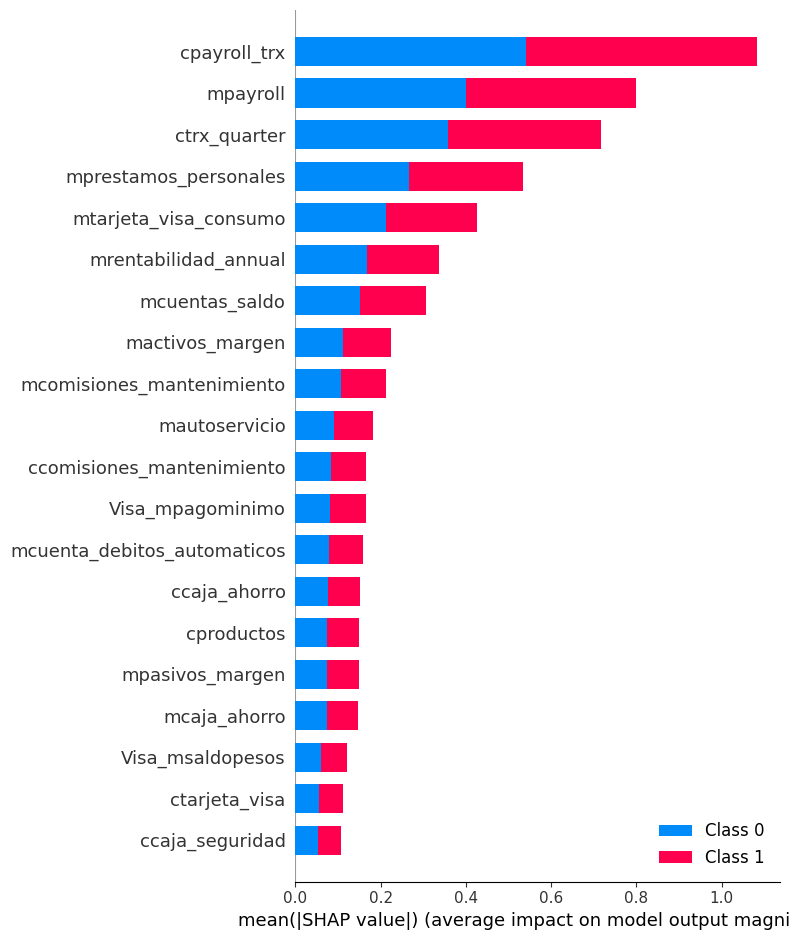

In [160]:
summary_plot = shap.summary_plot(shap_values_c3, Xbajas_c3)

In [175]:
df3_shap_imp = pd.DataFrame({'column': shap_importancias_c3.index, 'value': shap_importancias_c3.values})
df3_shap_imp[0:20]

,column,value
0,cpayroll_trx,0.541221
1,mpayroll,0.399602
2,ctrx_quarter,0.358905
3,mprestamos_personales,0.267109
4,mtarjeta_visa_consumo,0.212611
5,mrentabilidad_annual,0.167979
6,mcuentas_saldo,0.152770
7,mactivos_margen,0.111689
8,mcomisiones_mantenimiento,0.105955
9,mautoservicio,0.090677
